In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [65]:
# whisk = io.imread('./data/whisk_AV2_darker.tif')
# dff_whisk = calcDff(whisk, .2, 30)
whisk = io.imread('./data/whisk_AV2_nobackground.tif')
np.random.seed(42)
(length, lenx, leny) = whisk.shape
print(whisk.shape)
print(lenx,leny)

(53232, 123, 130)
123 130


In [45]:
def cropImage(imArr):
    (length, x, y, channel) = imArr.shape
    cropped = np.zeros((length, x+3, y+2, channel))
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            row1 = np.append(row,np.zeros(2))
            cropped[ind][rowind] = row1.reshape(y+2,1)
    return cropped
            
 

In [91]:
#though I was going to do multiple in this file but maybe if I have multiple 
data = whisk

In [92]:
num_data = len(data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test+num_val, (lenx*leny))

In [93]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [94]:
x_test_scaled = x_scaler.transform(x_test)

In [103]:
input_img = Input(shape=(lenx+3, leny+2, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(60, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((3, 2), padding='same')(x)
x = Conv2D(24, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 2), padding='same')(x)
x = Conv2D(14, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 3), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# x = Dense(2000, activation='relu')(encoded)
x = Conv2D(14, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 3))(x)
x = Conv2D(24, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((3, 2))(x)
x = Conv2D(60, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((3, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [88]:
input_img = Input(shape=((lenx+3)*(leny+2),))
x = Dense(500, activation='sigmoid')(input_img)
x = Dense(((lenx+3)*(leny+2)), activation='sigmoid')(x)
otherencoder = Model(input_img, x)
otherencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [104]:
autoencoder.summary()
# otherencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 126, 132, 1)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 126, 132, 60)      300       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 42, 66, 60)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 42, 66, 24)        5784      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 33, 24)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 33, 14)        1358      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 11, 14)         0         
__________

In [95]:
print(lenx,leny)
x_train = x_train_scaled.reshape((num_train, lenx,leny,1))
x_test = x_test_scaled.reshape((num_test+num_val, lenx, leny, 1))
print(x_test.shape)
x_train = cropImage(x_train)
x_test = cropImage(x_test)
print(x_test.shape)

123 130
(15970, 123, 130, 1)
(15970, 126, 132, 1)


In [ ]:
x_train = x_train.reshape((num_train, (lenx+3)*(leny+2)))
x_test = x_test.reshape((num_test+num_val, (lenx+3)*(leny+2)))

In [96]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [97]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [98]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [99]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [100]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(37262, 126, 132, 1)


In [105]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 37262 samples, validate on 15970 samples
Epoch 1/30
37262/37262 [==============================] - 135s 4ms/step - loss: 0.5215 - val_loss: 0.5246

Epoch 00001: val_loss did not improve from 0.47562
Epoch 2/30
37262/37262 [==============================] - 136s 4ms/step - loss: 0.4993 - val_loss: 0.5076

Epoch 00002: val_loss did not improve from 0.47562
Epoch 3/30
37262/37262 [==============================] - 135s 4ms/step - loss: 0.4894 - val_loss: 0.5071

Epoch 00003: val_loss did not improve from 0.47562
Epoch 4/30
37262/37262 [==============================] - 137s 4ms/step - loss: 0.4835 - val_loss: 0.5007

Epoch 00004: val_loss did not improve from 0.47562
Epoch 5/30
37262/37262 [==============================] - 136s 4ms/step - loss: 0.4809 - val_loss: 0.4976

Epoch 00005: val_loss did not improve from 0.47562
Epoch 6/30
37262/37262 [==============================] - 139s 4ms/step - loss: 0.4787 - val_loss: 0.4971

Epoch 00006: val_loss did not improve from 0.47562
Ep

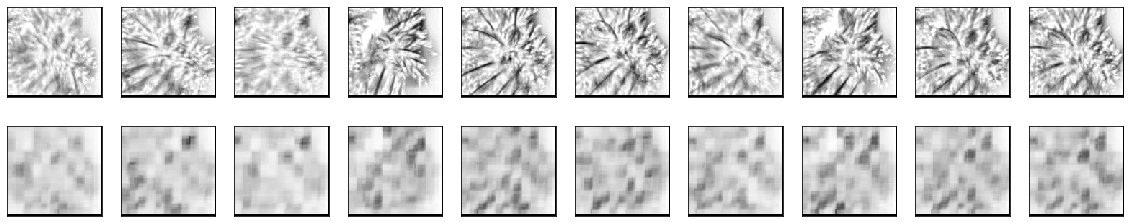

In [106]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+30].reshape(lenx+3, leny+2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+30].reshape(lenx+3, leny+2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [107]:
autoencoder.save('whiskEncodernobg2.h5')